<a href="https://colab.research.google.com/github/Pety99/food101/blob/main/food11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
!pip install -U tensorflow_datasets
!pip install tfa-nightly

Requirement already up-to-date: tensorflow_datasets in /usr/local/lib/python3.6/dist-packages (4.1.0)


In [47]:
import tensorflow as tf

In [48]:
# Import TensorFlow Datasets
import tensorflow_datasets as tfds
import tensorflow_addons as tfa

import tensorflow_hub as hub
#tfds.disable_progress_bar()

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers


In [49]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [50]:
import io
import itertools
import sklearn.metrics
from sklearn.model_selection import train_test_split
from datetime import datetime

# Adathalmaz letöltése a TensorFlow Datasets-ről
A [food101](https://www.tensorflow.org/datasets/catalog/food101) adathalmazt fogjuk használni, amiben 101000 kép található 101 külöböző kategóriába tartozó ételről, kategóriánként 1000 képpel. Az adathalmazt elszeparáltuk egy train és egy validációs halmazra. Az adatokból, most csak az első 11 oszlopot fogjuk használni.


In [51]:
USED_CLASSES = 25
dataset, metadata = tfds.load('food101', as_supervised=True, with_info=True)
train_dataset, validation_dataset = dataset['train'], dataset['validation']

train_dataset = train_dataset.filter(lambda img, label: label < USED_CLASSES)
validation_dataset = validation_dataset.filter(lambda img, label: label < USED_CLASSES)


#Pár információ az adatokról

In [52]:
num_classes = metadata.features['label'].num_classes // 101 * USED_CLASSES
num_train_examples = metadata.splits['train'].num_examples // 101 * USED_CLASSES
num_val_examples = metadata.splits['validation'].num_examples // 101 * USED_CLASSES


print('Total Number of Classes: {}'.format(num_classes))
print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples:{}".format(num_val_examples))


Total Number of Classes: 25
Number of training examples: 18750
Number of validation examples:6250


Látható, hogy nem minden kép ugyan akkora, tehát majd át kell méretezni őket.

In [53]:
for i, example in enumerate(train_dataset.take(10)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))


Image 1 shape: (512, 512, 3) label: 21
Image 2 shape: (512, 512, 3) label: 10
Image 3 shape: (384, 512, 3) label: 21
Image 4 shape: (382, 512, 3) label: 19
Image 5 shape: (512, 512, 3) label: 4
Image 6 shape: (512, 512, 3) label: 11
Image 7 shape: (342, 512, 3) label: 18
Image 8 shape: (384, 512, 3) label: 22
Image 9 shape: (384, 512, 3) label: 2
Image 10 shape: (341, 512, 3) label: 8


Ezekből a kategóriákból fogunk képeket kiválasztani:

In [54]:
class_names = np.array(metadata.features['label'].names)[:num_classes]

print(class_names)

['apple_pie' 'baby_back_ribs' 'baklava' 'beef_carpaccio' 'beef_tartare'
 'beet_salad' 'beignets' 'bibimbap' 'bread_pudding' 'breakfast_burrito'
 'bruschetta' 'caesar_salad' 'cannoli' 'caprese_salad' 'carrot_cake'
 'ceviche' 'cheesecake' 'cheese_plate' 'chicken_curry'
 'chicken_quesadilla' 'chicken_wings' 'chocolate_cake' 'chocolate_mousse'
 'churros' 'clam_chowder']


In [55]:
labels = []
images = []
for i, example in enumerate(validation_dataset):
  labels.append(example[1])
  images.append(example[0])

  IMAGE_RES = 224

_images = []
for img in images:
  img = tf.image.resize(img, (IMAGE_RES, IMAGE_RES))/255.0
  _images.append(img)

#the number of the class
_labels = []
for images, labels in validation_dataset.take(-1):
  _labels.append(labels.numpy())

#name of that class
_names = []
for n in _labels:
  _names.append(class_names[n-1])   #e.g. class number 3 --> class_names[2] = baklava


In [56]:
print(_labels[3])
print(_names[3])

3
baklava


In [57]:
#the origanal labels of the validation dataset
print(_names)

['breakfast_burrito', 'baklava', 'beef_carpaccio', 'baklava', 'bibimbap', 'cheesecake', 'apple_pie', 'apple_pie', 'beet_salad', 'carrot_cake', 'caesar_salad', 'beignets', 'baklava', 'beet_salad', 'cannoli', 'chicken_wings', 'apple_pie', 'ceviche', 'clam_chowder', 'apple_pie', 'carrot_cake', 'beef_carpaccio', 'carrot_cake', 'chicken_curry', 'apple_pie', 'caesar_salad', 'chocolate_mousse', 'cheese_plate', 'ceviche', 'chocolate_mousse', 'cannoli', 'beef_tartare', 'chicken_quesadilla', 'ceviche', 'caesar_salad', 'cheesecake', 'cannoli', 'churros', 'bread_pudding', 'caesar_salad', 'beet_salad', 'bread_pudding', 'beignets', 'breakfast_burrito', 'ceviche', 'bread_pudding', 'chocolate_cake', 'chicken_wings', 'baklava', 'chocolate_cake', 'caesar_salad', 'beet_salad', 'chocolate_mousse', 'beet_salad', 'caesar_salad', 'beef_carpaccio', 'chicken_curry', 'ceviche', 'beef_carpaccio', 'beef_carpaccio', 'caprese_salad', 'cheesecake', 'chocolate_cake', 'cheesecake', 'beet_salad', 'churros', 'caesar_sal

#Képek átméretezése és Batchelése

Az első modellhez: ~~[Inception ResNet V2](https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/4) 299x299~~ [MobileNet V2](https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4) 224 x 224 es képekre van szükség, szóval át kell őket méretezni.

In [58]:
IMAGE_RES = 224

def format_image(image, label):
  
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0

  return image, label

def rotate_image(image, label):
    if image.shape.__len__() ==4:
        random_angles = tf.random.uniform(shape = (tf.shape(image)[0], ), minval = -np
        .pi / 4, maxval = np.pi / 4)
    if image.shape.__len__() ==3:
        random_angles = tf.random.uniform(shape = (), minval = -np
        .pi / 4, maxval = np.pi / 4)

    return tfa.image.rotate(image,random_angles, interpolation='BILINEAR'), label

def flip_image(image, label):
  x = np.random.randint(0, 2);
  if(x == 0):
   image = tf.image.flip_left_right(image)

  return image, label

def zoom_image(image,label):
  scales = list(np.arange(0.6, 1.0, 0.01))
  boxes = np.zeros((len(scales), 4))

  for i, scale in enumerate(scales):
      x1 = y1 = (0.5 - (0.5 * scale))
      x2 = y2 = (0.5 + (0.5 * scale))
      boxes[i] = [x1, y1, x2, y2]

  def random_crop(img):
      # különböző vágások
      crops = tf.image.crop_and_resize([img], boxes=boxes, box_indices=np.zeros(len(scales)), crop_size=(IMAGE_RES, IMAGE_RES))
      # kiválasztunk egyet random
      return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]

  random_crop(image)
  return image,label

BATCH_SIZE = 32

train_batches = train_dataset.shuffle(num_train_examples //4).map(format_image).map(rotate_image).map(flip_image).map(zoom_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_dataset.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [59]:
train_dataset = train_dataset.map(rotate_image).map(flip_image).map(zoom_image) # map first is too slow in first time

# Pár kép az adatok közül

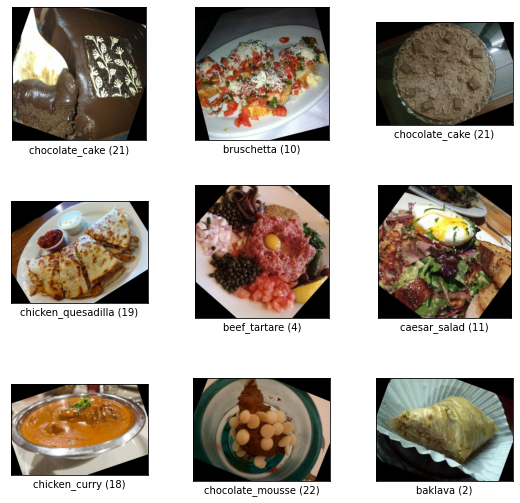

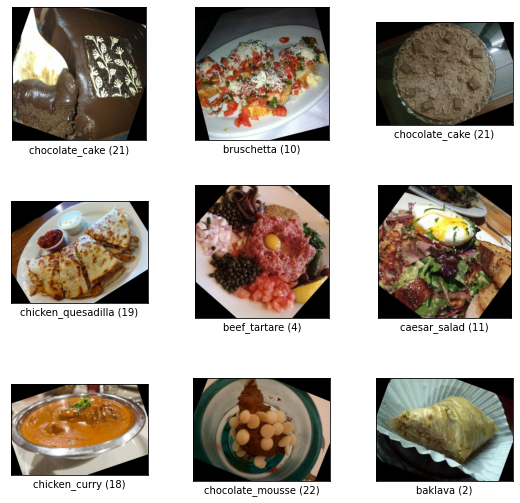

In [60]:
tfds.visualization.show_examples(
    train_dataset,
    metadata
)

# Transfer Learning
Az ~~[Inception ResNet V2](https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/4)~~ [MobileNet V2](https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4) modellt használjuk, és kibővítjük egy utolsó klasszifikáló réteggel.

In [61]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES, 3))

In [ ]:
#Ez a régi modell
CLASSIFIER_URL ="https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/4"
feature_extractor = hub.KerasLayer(CLASSIFIER_URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES, 3))

In [ ]:
feature_extractor.trainable = False

In [ ]:
model = tf.keras.Sequential([           
  feature_extractor,
  layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 25)                32025     
Total params: 2,290,009
Trainable params: 32,025
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 10

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/10
586/586 [==============================] - 241s 411ms/step - loss: 1.5568 - accuracy: 0.5433 - val_loss: 1.0738 - val_accuracy: 0.6752
Epoch 2/10
586/586 [==============================] - 218s 373ms/step - loss: 1.1497 - accuracy: 0.6546 - val_loss: 1.0186 - val_accuracy: 0.6864
Epoch 3/10
586/586 [==============================] - 213s 363ms/step - loss: 1.0544 - accuracy: 0.6817 - val_loss: 0.9649 - val_accuracy: 0.7086
Epoch 4/10
586/586 [==============================] - 220s 376ms/step - loss: 0.9897 - accuracy: 0.7005 - val_loss: 0.9828 - val_accuracy: 0.7021
Epoch 5/10
586/586 [==============================] - 201s 344ms/step - loss: 0.9506 - accuracy: 0.7118 - val_loss: 0.9379 - val_accuracy: 0.7194
Epoch 6/10
586/586 [==============================] - 231s 393ms/step - loss: 0.9135 - accuracy: 0.7226 - val_loss: 0.9529 - val_accuracy: 0.7136
Epoch 7/10
586/586 [==============================] - 252s 430ms/step - loss: 0.8891 - accuracy: 0.7279 - val_loss: 0.9478 -

# Eredmények

In [ ]:
pred = model.predict(validation_batches)

In [ ]:
preds = list(pred)

prediction=tf.argmax(preds,1)
print(prediction)

tf.Tensor([10  3 20 10 ... 22 13 17 22], shape=(6250,), dtype=int64)


In [ ]:
#the predicted labels
_preds = []
for n in prediction.numpy():
  _preds.append(class_names[n-1]) 

In [ ]:
print(_preds)

['breakfast_burrito', 'baklava', 'chicken_quesadilla', 'breakfast_burrito', 'clam_chowder', 'bread_pudding', 'apple_pie', 'apple_pie', 'beet_salad', 'carrot_cake', 'caesar_salad', 'beignets', 'baklava', 'beet_salad', 'cannoli', 'chicken_wings', 'apple_pie', 'ceviche', 'bread_pudding', 'chicken_quesadilla', 'carrot_cake', 'beef_carpaccio', 'carrot_cake', 'chicken_curry', 'apple_pie', 'caesar_salad', 'chocolate_mousse', 'chicken_quesadilla', 'ceviche', 'chocolate_mousse', 'breakfast_burrito', 'beef_tartare', 'apple_pie', 'chocolate_cake', 'caesar_salad', 'cheesecake', 'cannoli', 'ceviche', 'bread_pudding', 'caesar_salad', 'beet_salad', 'bread_pudding', 'beignets', 'breakfast_burrito', 'ceviche', 'bread_pudding', 'chocolate_cake', 'chicken_wings', 'baklava', 'ceviche', 'caesar_salad', 'beet_salad', 'chocolate_mousse', 'chocolate_cake', 'caesar_salad', 'cheesecake', 'bread_pudding', 'ceviche', 'beef_carpaccio', 'beef_carpaccio', 'ceviche', 'cheesecake', 'chocolate_cake', 'cheesecake', 'bee

In [ ]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

#plot confusion matrix
cm = confusion_matrix(_names, _preds, class_names)

# disp = plot_confusion_matrix(history, _preds, _names,
#                                  display_labels=class_names,
#                                  cmap=plt.cm.Blues)
print(cm)

[[201   0   0   3 ...   1   3   0   4]
 [  0 182   1   0 ...   0   1   1  15]
 [  0   0 181   6 ...   1   0   0   1]
 [  4   1  18 155 ...   2   1   0   3]
 ...
 [  0   1   0   0 ... 162   1   3   2]
 [  1   4   0   2 ...   7 198   0   4]
 [  0   1   0   1 ...   4   0 230   0]
 [  4  13   0   3 ...   8   2   2 127]]


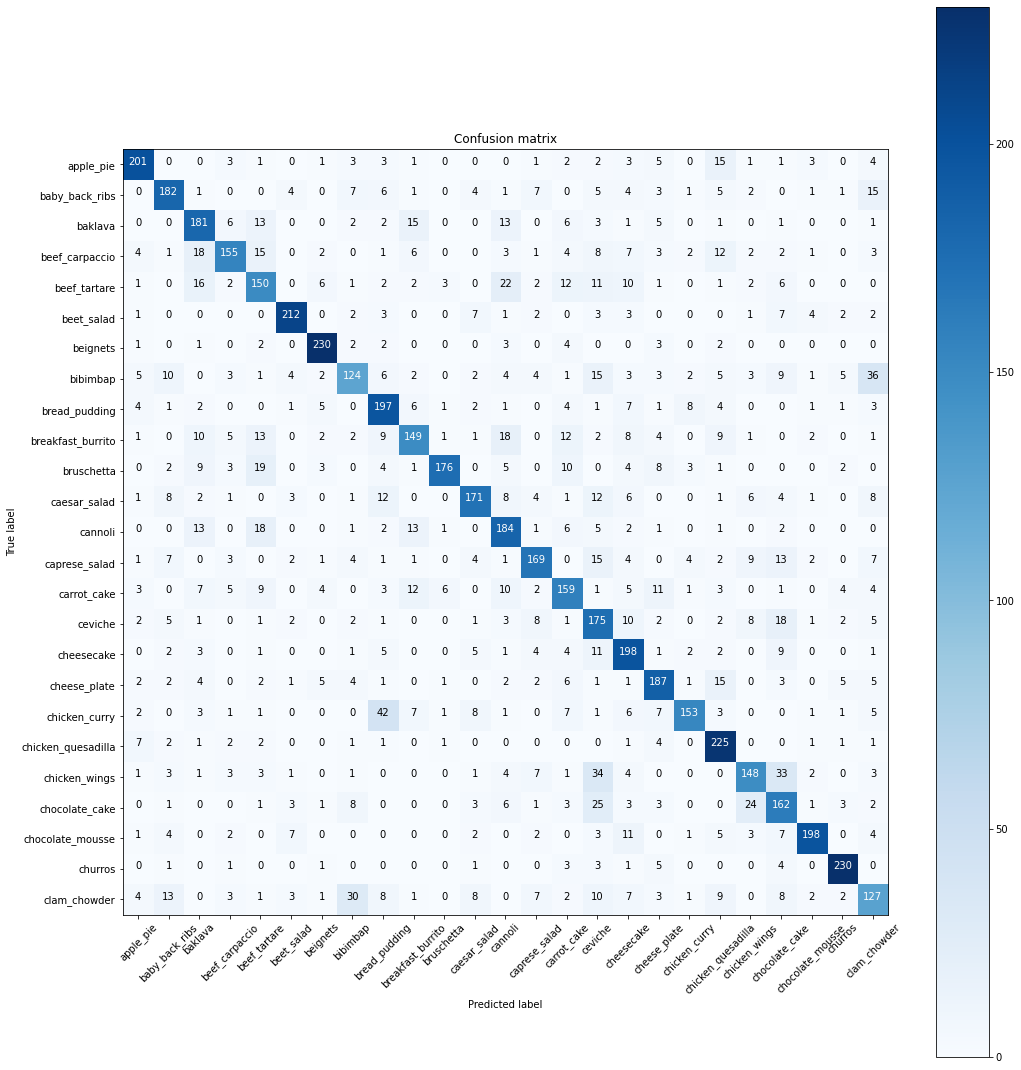

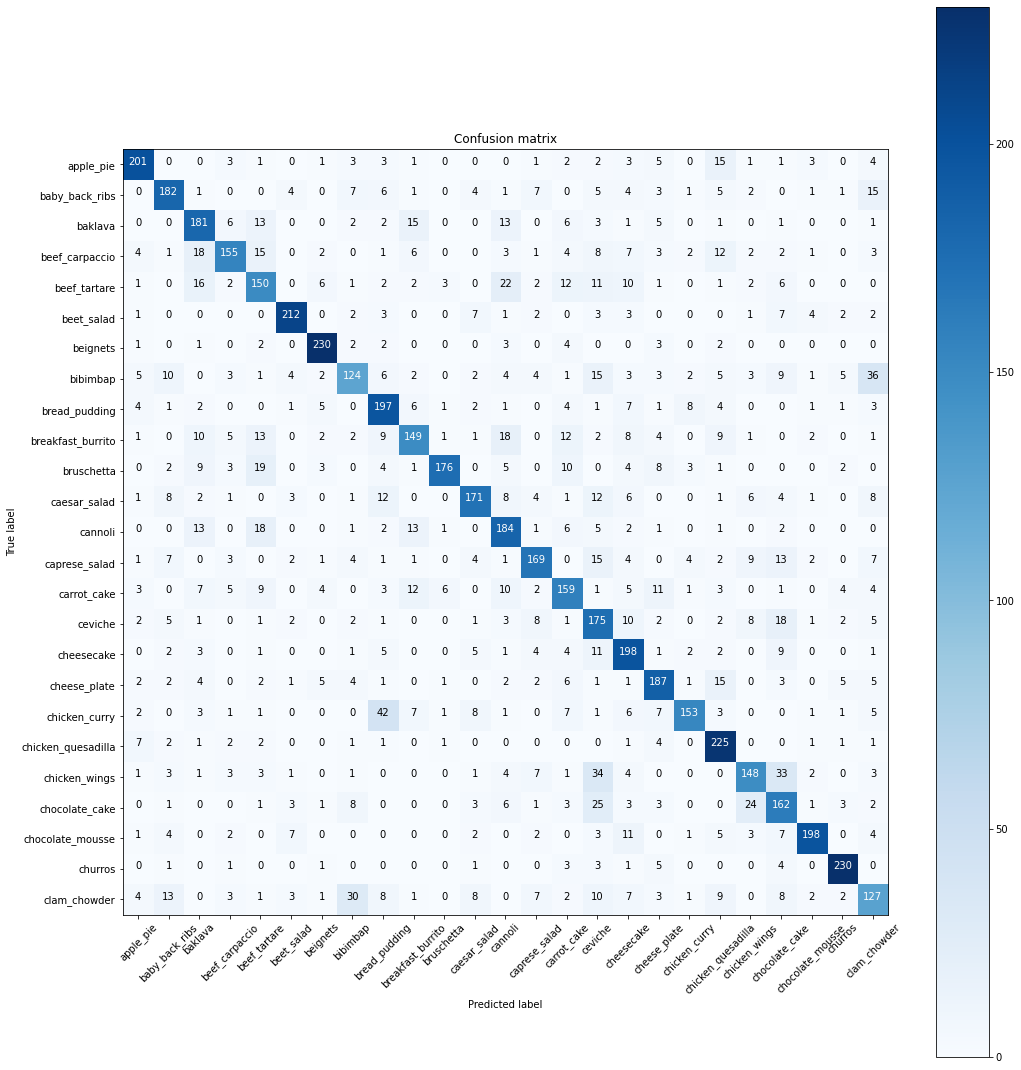

In [ ]:
def plot_confusion_matrix(cm, class_names):
    
    figure = plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Normalize the confusion matrix.
    #cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

plot_confusion_matrix(cm, class_names)

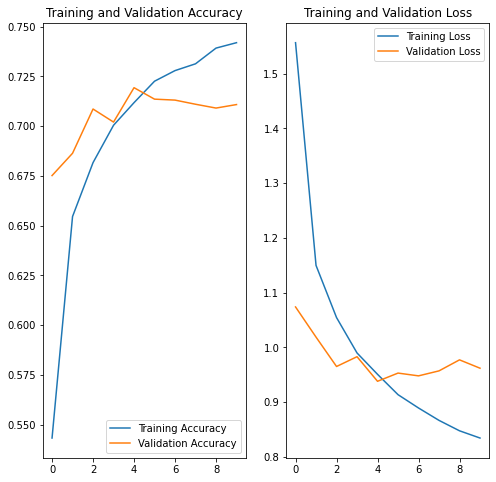

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

['bruschetta' 'beef_carpaccio' 'beef_tartare' 'bruschetta' 'bread_pudding'
 'chicken_quesadilla' 'baby_back_ribs' 'baby_back_ribs' 'beignets'
 'ceviche' 'cannoli' 'bibimbap' 'beef_carpaccio' 'beignets'
 'caprese_salad' 'chocolate_cake' 'baby_back_ribs' 'cheesecake'
 'breakfast_burrito' 'chicken_wings' 'ceviche' 'beef_tartare' 'ceviche'
 'chicken_quesadilla' 'churros' 'cannoli' 'churros' 'chicken_wings'
 'carrot_cake' 'churros' 'bruschetta' 'beet_salad']
Labels:            [10  3  4  3  8 17  1  1  6 15 12  7  3  6 13 21  1 16  0  1 15  4 15 19
  1 12 23 18 16 23 13  5]
Predicted labels:  [10  3  4 10  8 19  1  1  6 15 12  7  3  6 13 21  1 16  9 20 15  4 15 19
 23 12 23 20 14 23 10  5]


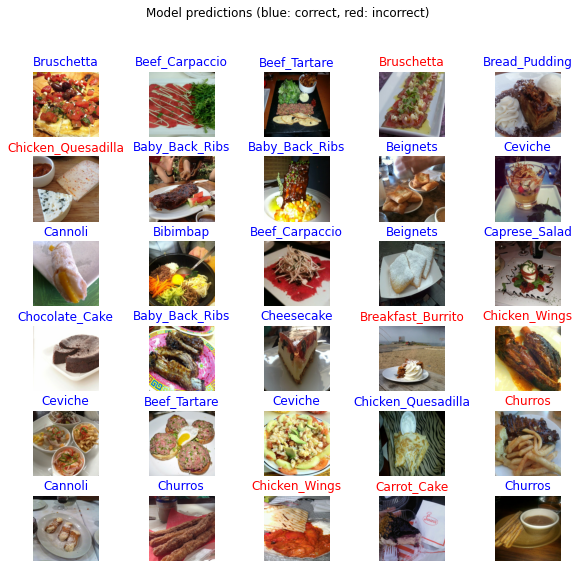

In [63]:
image_batch, label_batch = next(iter(validation_batches))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

